In [2]:
import torch
from loss import *

In [5]:
# Calculate the expected loss manually (using MSE loss)
mse_loss = nn.MSELoss(reduction="none")
masked_loss = MaskedLoss(mse_loss)


y_hat = torch.tensor(
    [
        [[0.9, 0.8], [0.7, 0.6], [0.5, 0.4], [0.3, 0.2], [0.1, 0.0]],
        [[0.5, 0.6], [0.7, 0.8], [0.9, 1.0], [1.1, 1.2], [1.3, 1.4]],
        [[1.0, 0.9], [0.8, 0.7], [0.6, 0.5], [0.4, 0.3], [0.2, 0.1]],
    ],
    dtype=torch.float32,
)
y = torch.tensor(
    [
        [[1.0, 0.8], [0.7, 0.6], [0.5, 0.4], [0.3, 0.2], [0.1, 0.0]],
        [[0.5, 0.6], [0.7, 0.8], [0.9, 1.0], [1.1, 1.2], [1.3, 1.4]],
        [[1.0, 0.9], [0.8, 0.7], [0.6, 0.5], [0.4, 0.3], [0.2, 0.1]],
    ],
    dtype=torch.float32,
)
mask = torch.tensor(
    [
        [1, 0, 1, 1, 0],
        [1, 1, 0, 1, 0],
        [1, 1, 1, 1, 1],
    ],
    dtype=torch.float32,
)

# Calculate the loss using the MaskedLoss class
masked_loss = masked_loss.get_loss(y_hat, y, mask)
expected_loss = mse_loss(y_hat, y)

In [6]:
masked_loss

tensor(0.0005)

In [8]:
torch.sum(expected_loss)

tensor(0.0100)

In [1]:
import numpy as np

In [283]:
def calculate_directional_consistency(trajectory):
    """
    Calculate directional consistency of a 3D trajectory.

    Args:
        trajectory (numpy.ndarray): NumPy array of shape (num_frame, 3) representing the 3D trajectory.

    Returns:
        float: Variance of the angles between consecutive direction vectors.
    """
    if trajectory.shape[0] < 2:
        raise ValueError("Trajectory must have at least two data points for directional consistency calculation.")

    # Compute direction vectors between consecutive points
    direction_vectors = np.diff(trajectory, axis=0)

    # Calculate angles between consecutive direction vectors
    angles = []
    for i in range(1, len(direction_vectors)):
        v1 = direction_vectors[i - 1]
        v2 = direction_vectors[i]
        cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
        angles.append(angle)

    # Calculate variance of the angles
    variance = np.var(angles)

    return variance

# Example usage:
if __name__ == "__main__":
    # Create a sample 3D trajectory (num_frame, 3)
    sample_trajectory = np.array([[0.0, 0.0, 0.0],
                                   [1.0, 0.0, 0.0],
                                   [2.0, 0.0, 0.0],
                                   [2.0, 1.0, 0.0],
                                   [2.0, 2.0, 0.0]])
    
    sample_trajectory = np.random.rand(50, 3)

    # Calculate directional consistency
    variance = calculate_directional_consistency(sample_trajectory)

    print(f"Directional consistency (variance of angles): {variance}")


Directional consistency (variance of angles): 0.3138348994231784


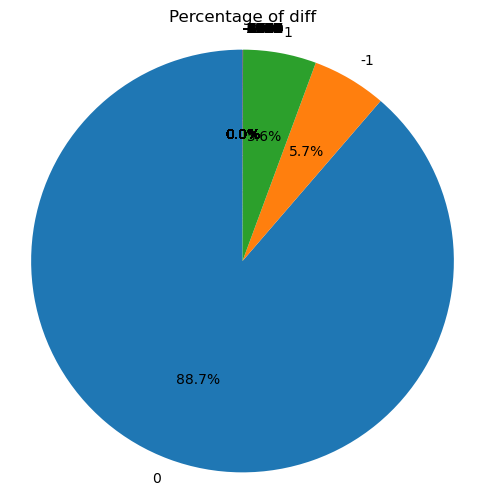

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from paths import bsc_path

log_path = os.path.join(bsc_path, "word_log.csv")
df = pd.read_csv(log_path)

# Specify the column you want to plot
column_to_plot = 'diff'

# Count the occurrences of each unique value
value_counts = df[column_to_plot].value_counts()

# Plot a pie chart
plt.figure(figsize=(6, 6))  # Adjust the figure size as needed
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(f'Percentage of {column_to_plot}')
plt.show()


"""
NOTE
There are very occasional words who lost n_frames. 
I am not sure whether we will encounter those in phones, just see. 
"""

In [2]:
import torchaudio
import os
from paths import *

In [3]:
rec, sr = torchaudio.load(os.path.join(bsc_path, "s0101a.wav"))

In [5]:
rec.size(1)

9969854

In [6]:
import pandas as pd

def assign_timestep(df, group_col):
    """
    Assign a "timestep" value to each row based on the order within the group.

    Parameters:
    - df (pandas.DataFrame): The input DataFrame.
    - group_col (str): The name of the column containing grouping information.

    Returns:
    - df (pandas.DataFrame): The DataFrame with an additional "timestep" column.
    """
    # Sort the DataFrame by the grouping column (optional but can be useful)
    df = df.sort_values(by=[group_col])

    # Group the DataFrame by the grouping column and assign timesteps within each group
    df['timestep'] = df.groupby(group_col).cumcount() + 1

    return df

# Example usage:
data = {'Group': ['A', 'A', 'B', 'A', 'B', 'B'],
        'Value': [10, 20, 5, 15, 8, 12]}
df = pd.DataFrame(data)

# Assign timesteps based on the 'Group' column
df = assign_timestep(df, 'Group')
print(df)


  Group  Value  timestep
0     A     10         1
1     A     20         2
3     A     15         3
2     B      5         1
4     B      8         2
5     B     12         3
